In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [24]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from datetime import datetime, date
import warnings
import timeit
from collections import defaultdict, OrderedDict
import time
from skimage import io, transform
import glob
import tables


timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

In [6]:
from iterative_lda import IterativeLDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

## Load MNIST


In [7]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

In [33]:
def extract_data(mnist, first_label, second_label):
    indices = np.logical_or(mnist.target == first_label, mnist.target == second_label)
    return mnist.data[indices], mnist.target[indices]

X, y = extract_data(mnist, 4, 9)
X.shape, y.shape

((13782, 784), (13782,))

## Fit an LDA model to the entire data-set

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=RANDOM_SEED,
                                                    stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12403, 784), (12403,), (1379, 784), (1379,))

In [35]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print(np.sum(lda.predict(X_train) == y_train) / y_train.shape[0])
print(np.sum(lda.predict(X_test) == y_test) / y_test.shape[0])

0.969442876723
0.960841189268


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [41]:
# raise ValueError('Dont run again')
ilda = IterativeLDA(5)
transformed_X_train = ilda.fit_transform(X_train, y_train)
transformed_X_test = ilda.transform(X_test)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [42]:
rfc = RandomForestClassifier(verbose=True)
rfc.fit(transformed_X_train, y_train)

print(np.sum(rfc.predict(transformed_X_train) == y_train) / y_train.shape[0])
print(np.sum(rfc.predict(transformed_X_test) == y_test) / y_test.shape[0])

0.994275578489
0.949963741842


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [43]:
svm = SVC(verbose=True)
svm.fit(transformed_X_train, y_train)

print(np.sum(svm.predict(transformed_X_train) == y_train) / y_train.shape[0])
print(np.sum(svm.predict(transformed_X_test) == y_test) / y_test.shape[0])

[LibSVM]0.969765379344
0.961566352429


## Examine projections a little bit

In [74]:
from sklearn.decomposition import PCA
pca_2 = PCA(n_components=2, whiten=False, copy=True)
pca_2.fit(X_train)
pca_projections_2 = pca_2.transform(X_test)
pca_reconstructions_2 = pca_2.inverse_transform(pca_projections_2).reshape((-1, 28, 28))

pca_5 = PCA(n_components=5, whiten=False, copy=True)
pca_5.fit(X_train)
pca_projections_5 = pca_5.transform(X_test)
pca_reconstructions_5 = pca_5.inverse_transform(pca_projections_5).reshape((-1, 28, 28))

lda_projections = lda.transform(X_test)
lda_reconstructions = (lda_projections.dot(lda.scalings_.T) + lda.xbar_).reshape((-1, 28, 28))
# lda_reconstructions = (lda_projections.dot(lda.coef_)).reshape((-1, 28, 28))

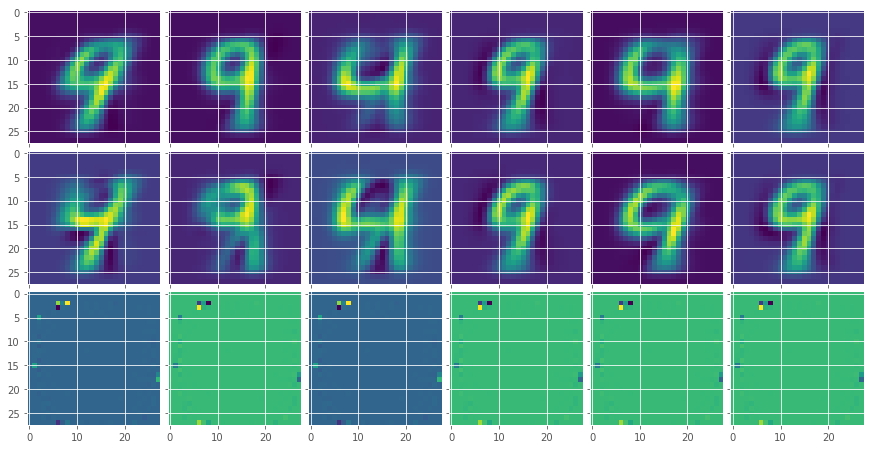

In [75]:
ROWS = 3
COLS = 6
HALF_COLS = COLS // 2

fig = plt.figure(1, (15, 25))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch
                )

for i in range(0, HALF_COLS):
    grid[i].imshow(pca_reconstructions_2[y_test == 4][i])
    grid[3 + i].imshow(pca_reconstructions_2[y_test == 9][i])
    grid[6 + i].imshow(pca_reconstructions_5[y_test == 4][i])
    grid[9 + i].imshow(pca_reconstructions_5[y_test == 9][i])
    grid[12 + i].imshow(lda_reconstructions[y_test == 4][i])
    grid[15 + i].imshow(lda_reconstructions[y_test == 9][i])


# for i in range(len(INTERESTING_INDICES)):
#     grid[2 * i].imshow(resized_array[INTERESTING_INDICES[i]]) 
#     grid[2 * i + 1].imshow(reshaped_reconstructions[INTERESTING_INDICES[i]]) 

# for ax in grid:
#     ax.grid(False)

plt.show()

In [48]:


# ilda_projections = transformed_X_test
# ilda_coef = np.hstack(l.coef_.shape)
# ilda_reconstructions = ilda_projections.dot(ilda_coef)

ValueError: shapes (1379,5) and (1,3910) not aligned: 5 (dim 1) != 1 (dim 0)

In [61]:
np.dot(X_test[0] - lda.xbar_, lda.scalings_), lda_projections[0]

(array([-2.95145503]), array([-2.95145503]))

In [71]:
().shape

(1379, 784)

In [70]:
X_test.shape

(1379, 784)